In [136]:
# IMPORTS
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import ndimage
from matplotlib.colors import LogNorm, PowerNorm

In [23]:
# FILES AND INITIAL DATA READ-IN
# file = "../../data/old/psliceout1.dat"
file = "../../data/old/psliceout_dm1e-2_c_br_n_5E14-5E13.dat"

ranked_file = "../local_rank_neighbours/output/ranked_1000neigh_psliceout1.dat"

# Read in data
print("Reading data & converting to np array.", flush=True)
data = pd.read_csv(file, sep='\s+', index_col=0, names=['x', 'y', 'z', 'vx', 'vy', 'vz', 'size'], header=None)

Reading data & converting to np array.


In [24]:
# BINS THE PARTICLES & CALC SURF DENS
# Prepare arrays
surfdens = np.zeros((500,500))
surfdens_norm = np.zeros((500,500))

#  Mass of something (warm solids?)
mswarm = 1.44e-5

# Calculate j and k using vectorized operations
print("Adjusting x-y units.", flush=True)
data['j'] = ((data['x'] + 60.0) / (120.0 / 500.0)).astype(int) - 1
data['k'] = ((data['y'] + 60.0) / (120.0 / 500.0)).astype(int) - 1

# Apply the condition (only one size?)
print("Updating surface density.", flush=True)
condition = (data['size'] > 1.0e-15) & (data['size'] < 1.0e-11)

# Update surfdens matrix with masses, and keep track of numbers
num = 0
for j, k in data[condition][['j', 'k']].values:
    surfdens[j, k] += mswarm
    num += 1

# Find the surface density
surfdens = surfdens/(120.0/500.0)/(120.0/500.0) # divide by the number of pixels and the range to scale the surfdens
avg_sdens = num*mswarm/120.0/120.0 # total mass divided by range
surfdens_norm = surfdens/avg_sdens # normalised surfdens

Adjusting x-y units.
Updating surface density.


In [25]:
# POPULATE THE IMAGE
image = []
for i in range(0,500):
    for j in range(0,500):
        # floor the normalised surface density at 0.0001
        if (surfdens_norm[i,j] < 0.0001):
            surfdens_norm[i,j] = 0.0001
        image.append(surfdens_norm[i,j])

image_log = np.log10(image)

In [26]:
# CALCULATES THE ROCHE DENSITY
# Get the Roche density, assuming G=1, Omega=1, H_g=pi
# Taken from Baehr et al. 2020, Eqn. 23
G = 1
Omega_K = 1
H_g = np.pi
Sigma_R = np.sqrt(2*np.pi) * 3.5 * Omega_K**2 * H_g / G
print(f"Sigma_R = {Sigma_R:.4f}")

Sigma_R = 27.5618


In [27]:
# # PLOTS THE DENSITY DISTRIBUTION
# # Density distribution
# hist_y, hist_x =  np.histogram(image, bins = 50, range=(0.01,100.0))

# plt.loglog(hist_x[1:50], hist_y[0:49])
# plt.axvline(np.log10(Sigma_R/avg_sdens), color='r', ls='--', label=f"Roche surface density $\\Sigma_R = {Sigma_R:.4f}$")
# plt.xlabel('Relative density')
# plt.ylabel('N')

# plt.legend()
# plt.show()
# #  plt.close()

In [28]:
# # PLOTS 2D DENSITY CUT-THROUGH
# num_x, pos_x = np.histogram(data['x'], bins=500)
# dens_x = num_x / (120*120)
# pos_x = np.array([pos_x[i-1] + (pos_x[i] - pos_x[i-1])/2 for i in range(1,len(pos_x))])
# plt.plot(pos_x, dens_x)

In [29]:
# PREPARES THE 2D IMAGE
# Manipulate image
image2D = np.reshape(np.ravel(image),[500,500])
image2D_log = np.log10(image2D)
rotated_img = ndimage.rotate(image2D_log,0.0)

In [30]:
# # PLOTS 3D SURFACE PLOT
# from matplotlib import cm
# from matplotlib.ticker import LinearLocator

# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# X = np.linspace(-60, 60, 500)
# Y = np.linspace(-60, 60, 500)
# X, Y = np.meshgrid(X, Y)
# print(np.max(surfdens))
# floored_img = surfdens - Sigma_R
# floored_img[floored_img<0] = 0
# ax.plot_surface(X, Y, floored_img)


# # # Make data.
# # X = np.arange(-5, 5, 0.25)
# # Y = np.arange(-5, 5, 0.25)
# # X, Y = np.meshgrid(X, Y)
# # R = np.sqrt(X**2 + Y**2)
# # Z = np.sin(R)

# # # Plot the surface.
# # surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
# #                        linewidth=0, antialiased=False)

# # # Customize the z axis.
# # ax.set_zlim(-1.01, 1.01)
# # ax.zaxis.set_major_locator(LinearLocator(10))
# # # A StrMethodFormatter is used automatically
# # ax.zaxis.set_major_formatter('{x:.02f}')

# # # Add a color bar which maps values to colors.
# # fig.colorbar(surf, shrink=0.5, aspect=5)

# plt.show()
# floored_img[floored_img>0]

In [31]:
# FIND SKIMAGE PEAKS
# Import utils for detecting the peaks according to the Roche density
from skimage.feature import peak_local_max
from skimage.morphology import extrema

# Set h so that it is the Roche density times the dynamic range and use it to find peaks
dyn_range = np.max(rotated_img) - np.min(rotated_img)
log_norm_Sigma_R = np.log10(Sigma_R/avg_sdens)
h = log_norm_Sigma_R / dyn_range
# h_maxima = extrema.h_maxima(rotated_img, h)
# coordinates = peak_local_max(h_maxima, min_distance=0)
coordinates = peak_local_max(rotated_img, min_distance=1, threshold_rel=h)

46.19699999992894 4619.699999992894


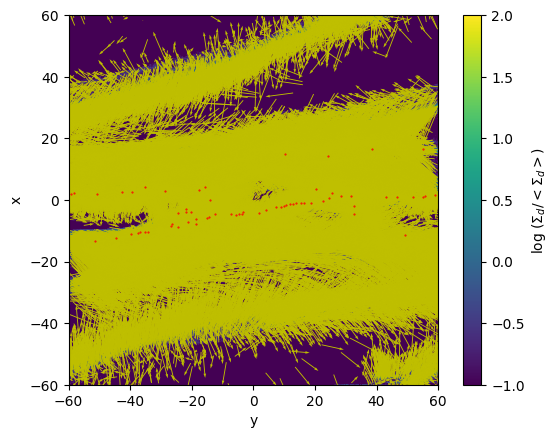

In [106]:
# PLOTS RAW PEAKS
# Plot raw data
plt.imshow(rotated_img, extent=[-60.0,60.0,-60.0,60.0],vmin=-1.0,vmax=2.0)

# Plot cbar
cbar = plt.colorbar(orientation='vertical')
cbar.set_label('log $(\Sigma_d/<\Sigma_d>)$',rotation=90)

# Plot peaks from image
plt.plot(coordinates[:, 1] * 120/500 - 60, coordinates[:, 0] * - 120/500 + 60, 'r.', ms=1)
# plt.plot(coordinates[:, 1] * 120/500 - 60, coordinates[:, 0] * - 120/500 + 60, 'ro', ms=7, mfc='none')

# # Plot peaks from ranked
# ranked = pd.read_csv(ranked_file, sep='\t', skiprows=1, names=['idx', 'radius', 'x', 'y', 'z'])
# plt.plot(ranked['y'][0], -ranked['x'][0], 'y.', ms=10)

# # Find & plot contours
# from skimage.measure import find_contours
# contours = find_contours(rotated_img, log_norm_Sigma_R)
# [plt.plot(contour[:, 1] * 120/500 - 60, contour[:, 0] * - 120/500 + 60, lw=.5, c='k') for contour in contours]
# plt.text((contours[0][0,1] * 120/500 - 60), (contours[0][0,0] * - 120/500 + 60) * .975, f"$\\Sigma_R/\\langle\\Sigma_d\\rangle={log_norm_Sigma_R:.3f}$", horizontalalignment="center")

# Other plot settings
# plt.xlim(-16.25,-15)
# plt.ylim(-11.25,-10)
# plt.xlim(20,40)
# plt.ylim(-60,0)
plt.xlabel('y')
plt.ylabel('x')

# Print info
print(np.max(surfdens), np.max(surfdens_norm))

# Plot vel disp
f = 100
x = data['x'][::f]
y = data['y'][::f]

u = data['vx'][::f]
v = data['vy'][::f]

plt.quiver(y, -x, v, -u, color='y', scale=100)
peak_x = coordinates[0,0] * - 120/500 + 60 # define peaks
peak_y = coordinates[0,1] * 120/500 - 60
# plt.ylim([peak_x - 2, peak_x + 2]) # define limits
# plt.xlim([peak_y - 2, peak_y + 2])

In [49]:
# # PLOTS SMOOTHED PEAKS
# image2D = np.reshape(np.ravel(image),[500,500])

# image2D_log = np.log10(image2D)

# rotated_img = ndimage.rotate(image2D_log,0.0)

# fwhm = 2
# sig = fwhm / (2 * np.sqrt(2 * np.log(2)))
# smoothed = ndimage.gaussian_filter(image2D_log, sigma=sig)

# # Set h so that it is the Roche density times the dynamic range
# dyn_range = np.max(smoothed) - np.min(smoothed)
# h = np.log10(Sigma_R/avg_sdens) / dyn_range

# # Plot the regions over the Roche density
# plt.imshow(rotated_img, extent=[-60.0,60.0,-60.0,60.0],vmin=np.log10(Sigma_R/avg_sdens),vmax=np.log10(Sigma_R/avg_sdens)*1.000000000001)

# # Now detecting the peaks according to the Roche density
# from skimage.feature import peak_local_max
# from skimage.morphology import extrema
# from skimage.measure import label
# from skimage import color

# # h_maxima = extrema.h_maxima(smoothed, h)
# # coordinates = peak_local_max(h_maxima, min_distance=0)
# # coordinates = peak_local_max(smoothed, min_distance=1, threshold_rel=h)
# # plt.plot(coordinates[:, 1] * 120/500 - 60, coordinates[:, 0] * - 120/500 + 60, 'r.', ms=1)
# cbar = plt.colorbar(orientation='vertical')
# cbar.set_label('log $(\Sigma_d/<\Sigma_d>)$',rotation=90)

# print(np.max(surfdens), np.max(surfdens_norm))

In [34]:
# # PLOTS ZOOMED VELOCITIES
# import os

# # Make output dir if doesn't exist
# outpath = "peaks_zoom_output"
# if not os.path.exists(outpath):
#     os.makedirs(outpath)

# # Start figure loop
# for i, coord in enumerate(coordinates):
#     # define peaks
#     peak_x = coord[0] * - 120/500 + 60
#     peak_y = coord[1] * 120/500 - 60

#     # define limits
#     xlim = [- peak_x - 2, - peak_x + 2]
#     ylim = [peak_y - 2, peak_y + 2]

#     # reduce data prior to plotting
#     data_red = data[((data['x'] > xlim[0]) & (data['x'] < xlim[1])) & ((data['y'] > ylim[0]) & (data['y'] < ylim[1]))]

#     # plot figure
#     fig, ax = plt.subplots()
#     ax.plot(peak_y, peak_x, 'r.', ms=5, label="skimage peak")

#     # Plot velocity vectors
#     f = 100
#     x = data_red['x'][::f]
#     y = data_red['y'][::f]

#     u = data_red['vx'][::f]
#     v = data_red['vy'][::f]

#     ax.quiver(y, -x, v, -u, color='y', scale=250)

#     plt.xlabel('y')
#     plt.ylabel('x')
#     plt.xlim(ylim)
#     plt.ylim([-xlim[0], -xlim[1]])
#     plt.legend()
#     plt.title(f"{file.strip('../').strip('.dat')}_peak{i}")
#     plt.savefig(f"peaks_zoom_output/{file.strip('../../data/old/').strip('.dat')}_peak{i}.png", format='png')
#     plt.close()

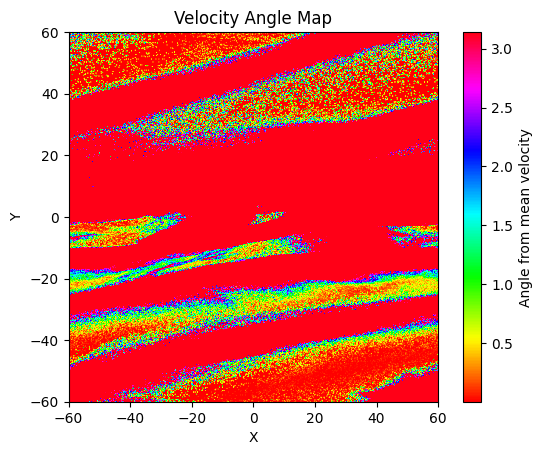

In [132]:
# PLOTS VELOCITIES
# Calculating mean velocity
mean_u = np.mean(data['vx'])
mean_v = np.mean(data['vy'])
mean_z = np.mean(data['vz'])
uvz_mean = np.sqrt(mean_u**2 + mean_v**2 + mean_z**2)
norm_uvz_mean = np.array([mean_u, mean_v, mean_z]) / mean_uvz
mean_uv = np.sqrt(mean_u**2 + mean_v**2)

# Calculate velocity vector angle differences from norm_uvz_mean
angles = np.arccos(np.dot(np.array([data['vx'], data['vy'], data['vz']]).T, norm_uvz_mean)/np.linalg.norm(np.array([data['vx'], data['vy'], data['vz']]).T, axis=1))

# Binning angles onto pixels
angle_grid = np.zeros((500, 500))
j_indices = ((data['x'] - 60.0) / - (120.0 / 500.0)).astype(int) - 1
k_indices = ((data['y'] + 60.0) / (120.0 / 500.0)).astype(int) - 1

# Accumulate angles in the grid
for j, k, a in zip(j_indices, k_indices, angles):
    if 0 <= j < 500 and 0 <= k < 500:  # Ensure indices are within grid bounds
        angle_grid[j, k] += a

# Plotting the result
plt.imshow(angle_grid, extent=[-60.0,60.0,-60.0,60.0], origin='lower', cmap='hsv', vmin=np.min(angles), vmax=np.max(angles))
plt.colorbar(label='Angle from mean velocity')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Velocity Angle Map')
plt.show()

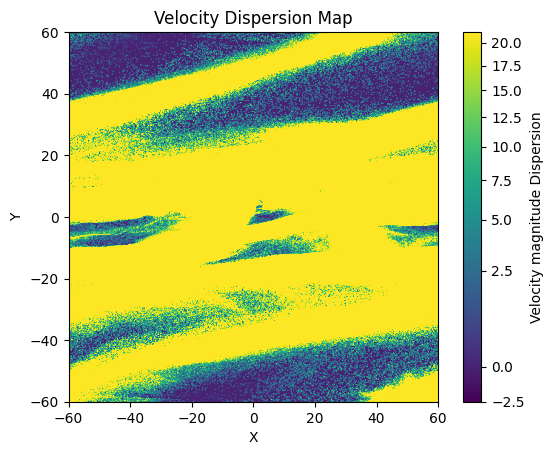

In [142]:
# Calculating velocity magnitude dispersion
disp = np.sqrt(data['vx']**2 + data['vy']**2) - mean_uv

# Binning dispersion onto pixels
disp_grid = np.zeros((500, 500))
j_indices = ((data['x'] - 60.0) / - (120.0 / 500.0)).astype(int) - 1
k_indices = ((data['y'] + 60.0) / (120.0 / 500.0)).astype(int) - 1

# Accumulate dispersion in the grid
for j, k, d in zip(j_indices, k_indices, disp):
    if 0 <= j < 500 and 0 <= k < 500:  # Ensure indices are within grid bounds
        disp_grid[j, k] += d

# Plotting the result
plt.imshow(disp_grid, extent=[-60.0,60.0,-60.0,60.0], origin='lower', cmap='viridis', norm=PowerNorm(gamma=.5, vmin=np.min(disp), vmax=np.max(disp)))
plt.colorbar(label='Velocity magnitude Dispersion')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Velocity Dispersion Map')
plt.show()

(array([7.63200e+03, 1.97980e+04, 3.48560e+04, 4.04090e+04, 5.65630e+04,
        7.30110e+04, 8.16500e+04, 1.08338e+05, 1.44685e+05, 1.55365e+05,
        2.21437e+05, 3.52312e+05, 2.69203e+05, 3.30844e+05, 3.35969e+05,
        3.36152e+05, 4.35824e+05, 3.48783e+05, 5.00984e+05, 3.78967e+05,
        3.38987e+05, 2.91469e+05, 3.84565e+05, 2.59737e+05, 2.22913e+05,
        2.00391e+05, 1.77460e+05, 1.67425e+05, 1.59656e+05, 1.48942e+05,
        1.86535e+05, 2.19053e+05, 3.03061e+05, 1.55383e+05, 1.62901e+05,
        1.66187e+05, 2.14537e+05, 2.06992e+05, 1.91597e+05, 1.67628e+05,
        2.12739e+05, 1.72071e+05, 1.52957e+05, 1.31644e+05, 1.37178e+05,
        1.35134e+05, 7.41460e+04, 6.32830e+04, 5.50460e+04, 4.50940e+04,
        3.76570e+04, 3.32190e+04, 2.84970e+04, 2.39280e+04, 1.95510e+04,
        1.62020e+04, 1.37390e+04, 1.18260e+04, 1.05610e+04, 9.26900e+03,
        8.16400e+03, 7.01100e+03, 6.38100e+03, 5.63700e+03, 4.91700e+03,
        4.22700e+03, 3.50300e+03, 3.05800e+03, 2.73

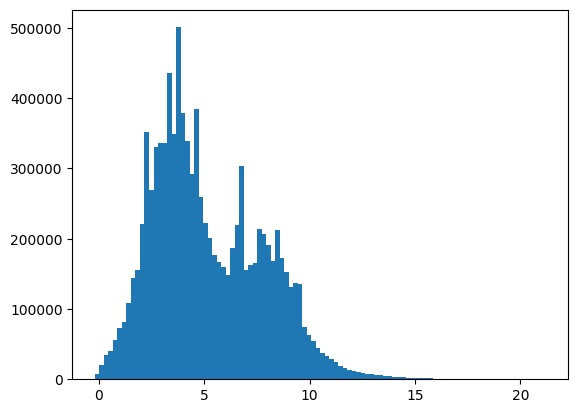

In [57]:
# Plots histogram of velocity dispersion
plt.hist(disp, bins=100)

104.70975000089457 10470.975000089456


/var/folders/2p/gmg4_q5d6nbd7rx98bwbch740000gn/T/ipykernel_97308/1268153826.py:3: RuntimeWarning: divide by zero encountered in divide
  return (c_s * kappa) / (np.pi * G * Sigma)


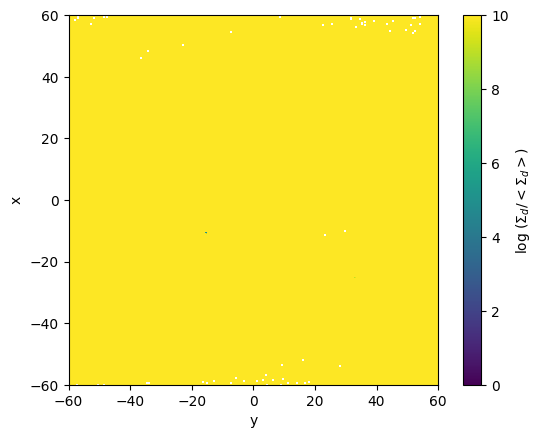

In [18]:
# PLOTS TOOMRE Q
def Toomre_Q(c_s, kappa, G, Sigma):
    return (c_s * kappa) / (np.pi * G * Sigma)

c_s = 5.5
Toomre_Q_2D = Toomre_Q(c_s, Omega_K, G, surfdens)
# Plot raw data
plt.imshow(Toomre_Q_2D, extent=[-60.0,60.0,-60.0,60.0],vmin=0,vmax=10.)

# Plot cbar
cbar = plt.colorbar(orientation='vertical')
cbar.set_label('log $(\Sigma_d/<\Sigma_d>)$',rotation=90)

# Plot peaks from image
# plt.plot(coordinates[:, 1] * 120/500 - 60, coordinates[:, 0] * - 120/500 + 60, 'r.', ms=1)
# plt.plot(coordinates[:, 1] * 120/500 - 60, coordinates[:, 0] * - 120/500 + 60, 'ro', ms=7, mfc='none')

# Other plot settings
# plt.xlim(-16.25,-15)
# plt.ylim(-11.25,-10)
# plt.xlim(20,40)
# plt.ylim(-60,0)
plt.xlabel('y')
plt.ylabel('x')

# Print info
print(np.max(surfdens), np.max(surfdens_norm))